In [1]:
#imports

import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from optimizers.optim import SGD_C, SGD, Adam_C, Adam, RMSprop, RMSprop_C
from analysis.optimizer_classes import Optimizer
from matplotlib.colors import LogNorm
from collections import OrderedDict

In [2]:
def init_plot(compute_loss, func_name):
    fig = plt.figure(figsize=(3, 3))

    sns.set_style('whitegrid') 
    sns.set_context("paper")
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    
    plt.axis('off')
    
    # visualize cost function as a contour plot
    if func_name == 'Beale':
        x_points = np.linspace(-2.0, 3.5, 50) 
        y_points = np.linspace(-3.0, 3.0, 50)
    if func_name == 'SixHumpCamel':
        x_points = np.linspace(-3.0, 3.5, 50) 
        y_points = np.linspace(-3.0, 3.0, 50)
    if func_name == 'GoldsteinPrice':
        x_points = np.linspace(-2.0, 1.0, 50) 
        y_points = np.linspace(-2.0, 1.0, 50)
    w1_val_mesh, w2_val_mesh = np.meshgrid(x_points, y_points)
    
    z = np.array([compute_loss([torch.tensor(xps), torch.tensor(yps)]).detach().numpy() for xps, yps in zip(w1_val_mesh, w2_val_mesh)])

    ax.contour(w1_val_mesh, w2_val_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.set_title(func_name)
    
    return fig, ax

def set_default(param):
    ret = {}
    ret['optimizer'] = param['optimizer']
    try:
        ret['lr'] = param['lr']
    except:
        ret['lr'] = 1e-4
    try:
        ret['decay'] = param['decay']
    except:
        ret['decay'] = 0.7
    try:
        ret['topC'] = param['topC']
    except:
        ret['topC'] = 5
    return ret

def main(func_name = 'Beale',n_epochs = 1000, params = [{'optimizer': 'SGD'}], plot_loss = False):
    
    optimizer_list = [Optimizer(param['optimizer'], func_name = func_name, lr = param['lr'], decay = param['decay'], topC = param['topC']) for param in params]

    fig, ax = init_plot(optimizer_list[0].loss_func.get_func_val, func_name = func_name)
    if plot_loss:
        plt.show()
    M_list = {} # minimum loss observed thus far

    for i in range(n_epochs):
        d = {}
        for j in range(len(optimizer_list)):
            model = optimizer_list[j]
            loss = model.train_step()
            ln = optimizer_list[j].plot(ax)
            d.update({params[j]['optimizer']: float(loss)})
        if i%100 == 0:
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = OrderedDict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys())
            if not os.path.exists('Figures'):
                os.makedirs('Figures')
            plt.savefig(os.path.join('Figures',func_name+'_'+str(i)+'.png'))
        M_list.update({i:d})
    plt.close()
          
    return M_list

def CompareOpts(func_name = 'Beale', params = [{'optimizer': 'SGD'}], plot_loss = False):
    param_fix = [set_default(param) for param in params]
    M_list = main(func_name, params = param_fix, plot_loss = plot_loss)
    fieldnames=['Epoch','Optimizer', 'Loss']
    target = open("temp.csv", "w")
    writer = csv.DictWriter(target, fieldnames=fieldnames)
    writer.writerow(dict(zip(fieldnames, fieldnames)))
    
    for i, rest in M_list.items():
        for opt_name, loss in rest.items():
            writer.writerow(dict([
                    ('Epoch', i),
                    ('Optimizer', opt_name),
                    ('Loss',loss)])
                    )
    target.close()
    sns.lineplot(x = 'Epoch', y = 'Loss', hue = 'Optimizer',data = pd.read_csv('temp.csv'))
    plt.title(func_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

## How to plot graphs using this notebook

The `CompareOpts` function allows you to plot comparisons of different optimizers and their _C variants.

Hyperparameters can be passed as a list of dictionnaries. When not specified, the learning rate `lr`, `decay`, and `topC` will default to 1e-4, 0.7, and 5 respectively.

Toggle `plot_loss` to plot the loss surface prior to the training curves.

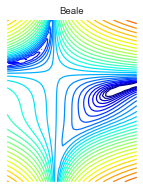

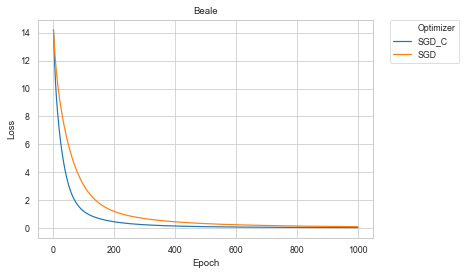

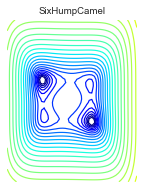

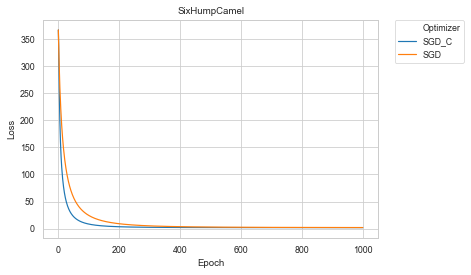

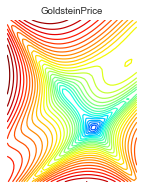

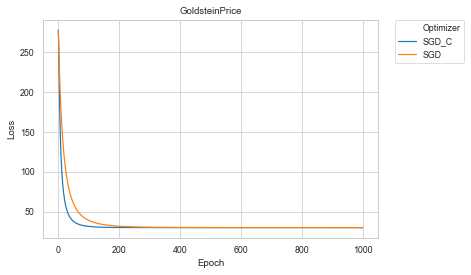

In [3]:
params = [
    {'optimizer': 'SGD_C', 'lr': 0.0001, 'decay': 0.7, 'topC': 5},
    {'optimizer': 'SGD', 'lr': 0.0001}   
]

for fn in ['Beale','SixHumpCamel','GoldsteinPrice']:
    CompareOpts(func_name = fn, params = params, plot_loss = True)